In [1]:
import javabridge
import bioformats
import numpy as np
from skimage.filters.rank import minimum
from skimage.morphology import disk
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = 7,7
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
javabridge.start_vm(class_path=bioformats.JARS)

In [5]:
#path = "2018-08-08_Wholemounts_p21_ANNA 488_DAPI_20X.lif"
path = "2018-08-30_Wholemounts_p21_ANNA_488_DAPI_20X.lif"

In [6]:
xml = bioformats.get_omexml_metadata(path)
md = bioformats.omexml.OMEXML(xml)

meta={'AcquisitionDate': md.image().AcquisitionDate}
meta['Name']=md.image().Name
meta['SizeC']=md.image().Pixels.SizeC
meta['SizeT']=md.image().Pixels.SizeT
meta['SizeX']=md.image().Pixels.SizeX
meta['SizeY']=md.image().Pixels.SizeY
meta['SizeZ']=md.image().Pixels.SizeZ
meta['PhysicalSizeX'] = md.image().Pixels.PhysicalSizeX
meta['PhysicalSizeY'] = md.image().Pixels.PhysicalSizeY
meta['PhysicalSizeZ'] = md.image().Pixels.PhysicalSizeZ

In [7]:
image = np.empty((meta['SizeT'], meta['SizeZ'], meta['SizeX'], meta['SizeY'], meta['SizeC']))

with bioformats.ImageReader(path) as rdr:
    for t in range(0, meta['SizeT']):
        for z in range(0, meta['SizeZ']):
            for c in  range(0, meta['SizeC']):
                image[t,z,:,:,c]=rdr.read(c=c, z=z, t=t, series=None, 
                                             index=None, rescale=False, wants_max_intensity=False, 
                                             channel_names=None)

In [8]:
javabridge.kill_vm()

In [9]:
image.shape

(1, 22, 4496, 4496, 1)

In [10]:
MIP = np.amax(image, 1)

In [11]:
MIP.shape

(1, 4496, 4496, 1)

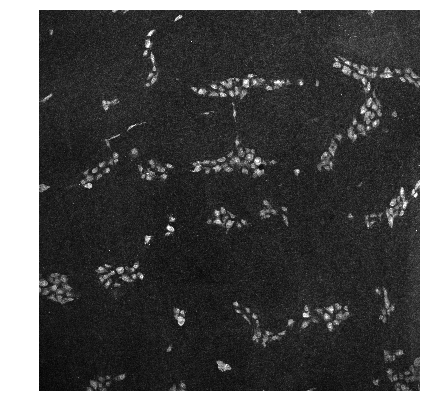

In [12]:
plt.imshow(MIP[0,:,:,0])
plt.axis('off')
plt.savefig('MIP.png',dpi=300)

In [13]:
to_anal = MIP[0,:,:,0].astype("uint16")

In [14]:
background = minimum(to_anal, disk(50))

/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/filters/rank/generic.py:102: UserWarning: Bitdepth of 15 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


In [15]:
result = to_anal - background

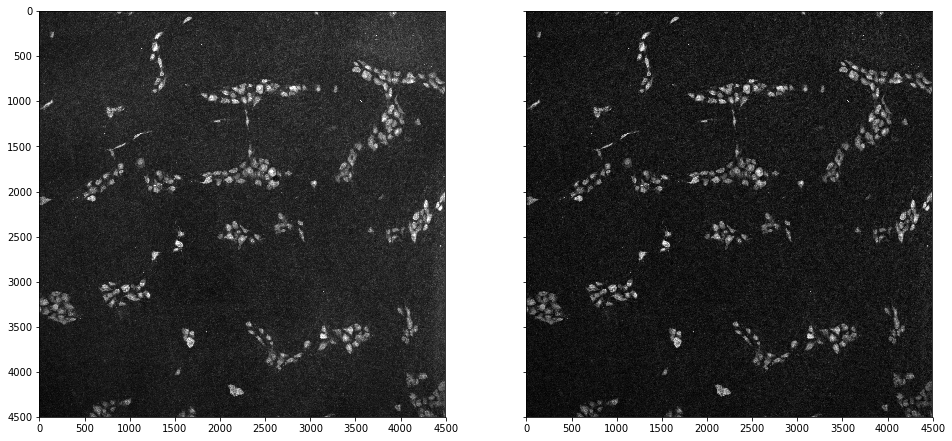

In [16]:
fig, (ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                       sharex=True, sharey=True)
ax[0].imshow(to_anal)
ax[1].imshow(result)

In [17]:
im = img_as_float(result)

# Denoise using non local means

In [18]:
sigma_est = np.mean(estimate_sigma(im, multichannel=False))

In [19]:
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=False)

In [20]:
denoise1_fast = denoise_nl_means(im, h=0.5 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)

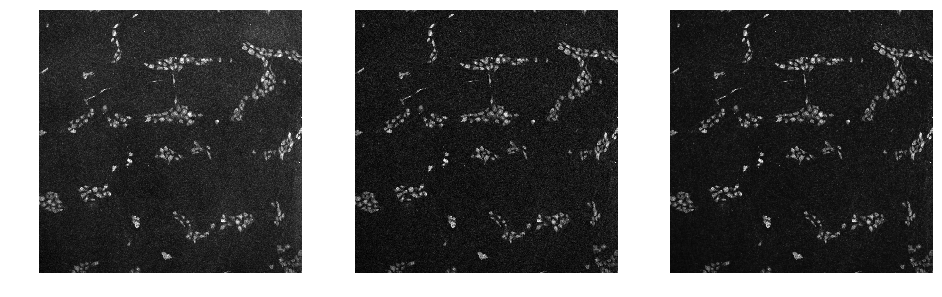

In [21]:
fig, (ax) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8),
                       sharex=True, sharey=True)
ax[0].imshow(to_anal)
ax[1].imshow(result)
ax[2].imshow(denoise1_fast)

for axes in ax:
    axes.axis('off')

# Segmentation

In [22]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
from skimage import filters
import scipy.ndimage as ndi
from skimage.morphology import opening, dilation
from skimage import feature
from skimage.segmentation import watershed

In [23]:
img = denoise1_fast

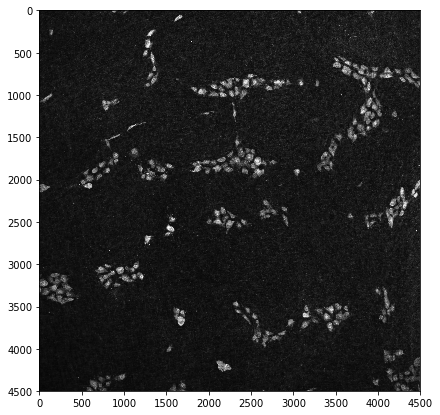

In [24]:
plt.imshow(img)

In [25]:
#m,n = denoise1_fast[1450:2000, 1700:2850].shape

In [26]:
#(m*n)/1000

In [27]:
m,n = img.shape
n_segments = (m*n)/632

In [28]:
np.ceil(n_segments)

31985.0

In [29]:
segments_slic = slic(img, n_segments=32000, compactness=0.3,  multichannel=False, sigma=0)

/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexi

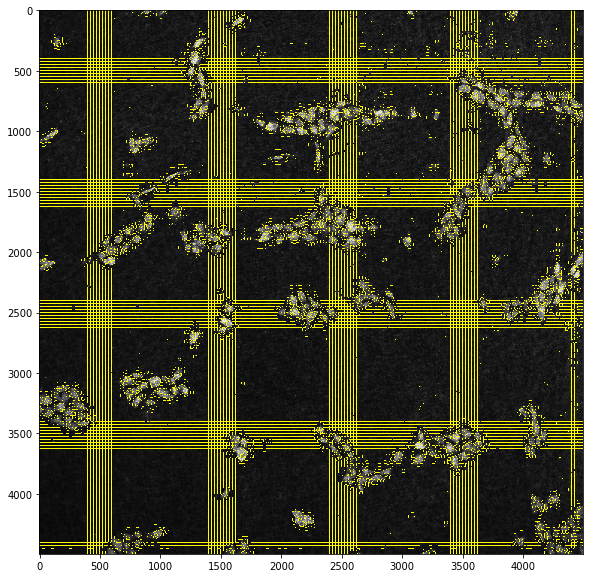

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)

ax.imshow(mark_boundaries(img, segments_slic))

In [31]:
props = regionprops(segments_slic, img)

In [32]:
img_relabel = np.copy(img)
for prop in props:
    img_relabel[tuple(prop.coords.T)] = prop.mean_intensity

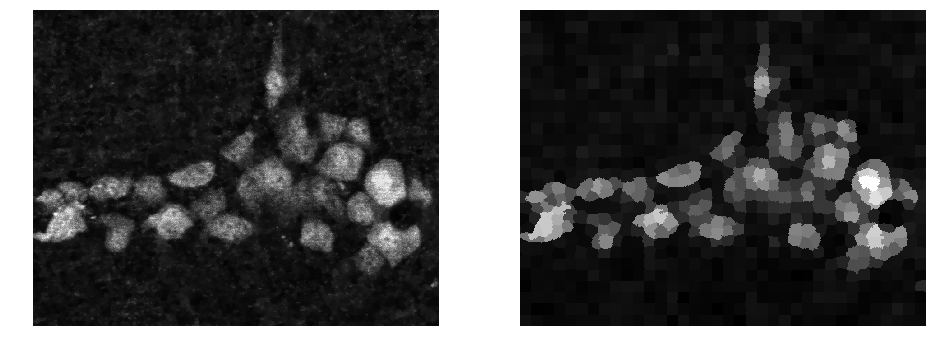

In [33]:
fig, (ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                       sharex=True, sharey=True)
ax[0].imshow(img[1400:2100, 1800:2700])
ax[1].imshow(img_relabel[1400:2100, 1800:2700])

for axes in ax:
    axes.axis('off')

#plt.savefig('SuperPixel.png',dpi=300)

In [34]:
thresh = filters.threshold_otsu(img_relabel)

In [35]:
binary = img_relabel > thresh*1.2

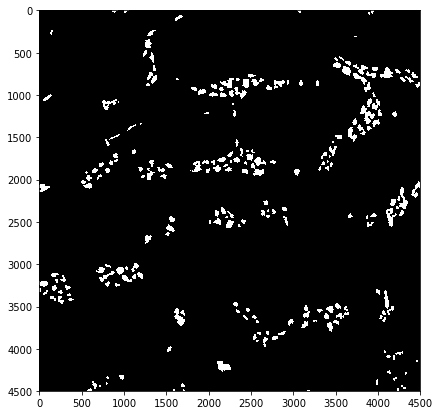

In [36]:
plt.imshow(binary)

### Create a mask of the background

In [37]:
mask = ~binary.astype(bool)

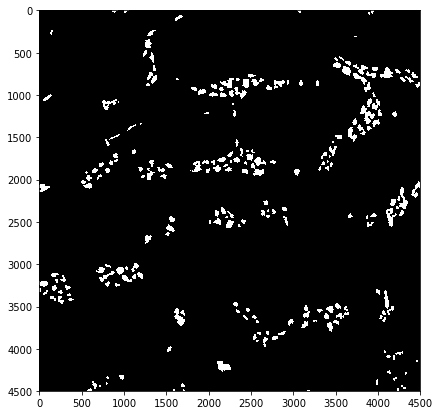

In [38]:
plt.imshow(~mask)

In [39]:
masked = np.copy(img_relabel)

In [40]:
masked[mask] = 0

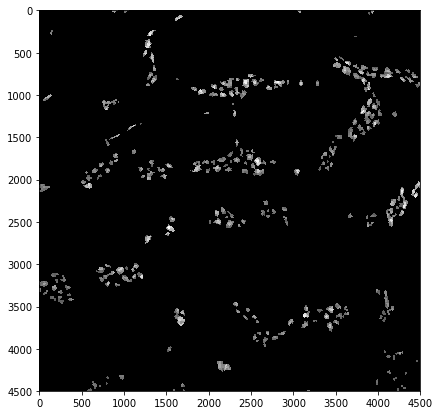

In [41]:
plt.imshow(masked)

In [42]:
binary =  opening(binary, disk(5))

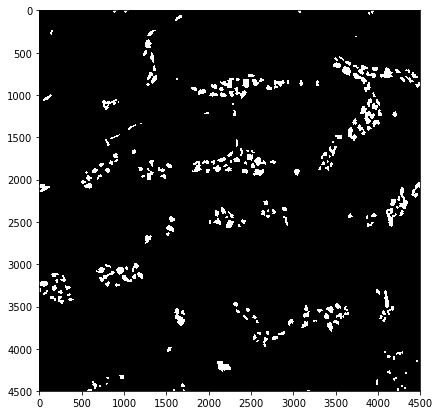

In [43]:
plt.imshow(binary)

In [44]:
dist = ndi.distance_transform_edt(binary)

(-0.5, 899.5, 699.5, -0.5)

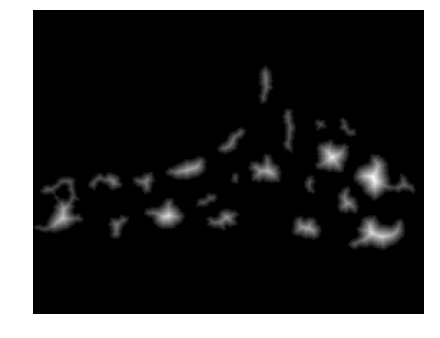

In [45]:
plt.imshow(dist[1400:2100, 1800:2700])
plt.axis('off')
#plt.savefig('distmap.png',dpi=300)

In [46]:
local_maxi = feature.peak_local_max(dist, min_distance = 40, threshold_abs = 10,
                                    exclude_border=False)
markers_lm = np.zeros(dist.shape, dtype=np.int)
markers_lm[local_maxi[:,0].astype(np.int), local_maxi[:,1].astype(np.int)] = np.arange(len(local_maxi[:,0])) + 1
markers_lm = dilation(markers_lm, disk(10))

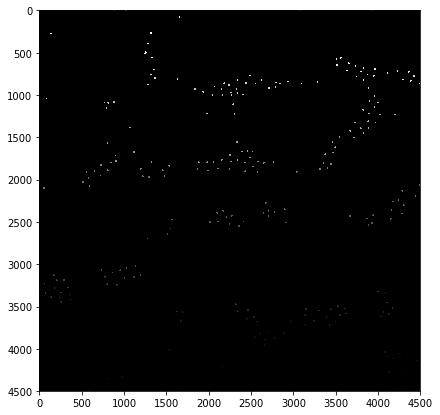

In [47]:
plt.imshow(markers_lm)

(-0.5, 899.5, 699.5, -0.5)

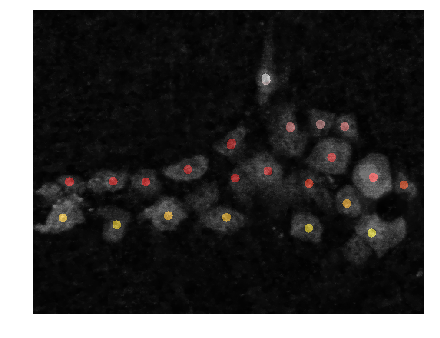

In [48]:
plt.imshow(img[1400:2100, 1800:2700])
plt.imshow(markers_lm[1400:2100, 1800:2700], cmap = "nipy_spectral", alpha = 0.5)
plt.axis('off')
#plt.savefig('localmax.png',dpi=300)

# Try clustering

In [49]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
X = local_maxi

In [52]:
X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.20, min_samples=6).fit(X)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [53]:
label_plot = np.copy(labels)

In [54]:
label_plot[labels == 0] = max(labels)+1

In [55]:
label_plot[labels == -1] = 0

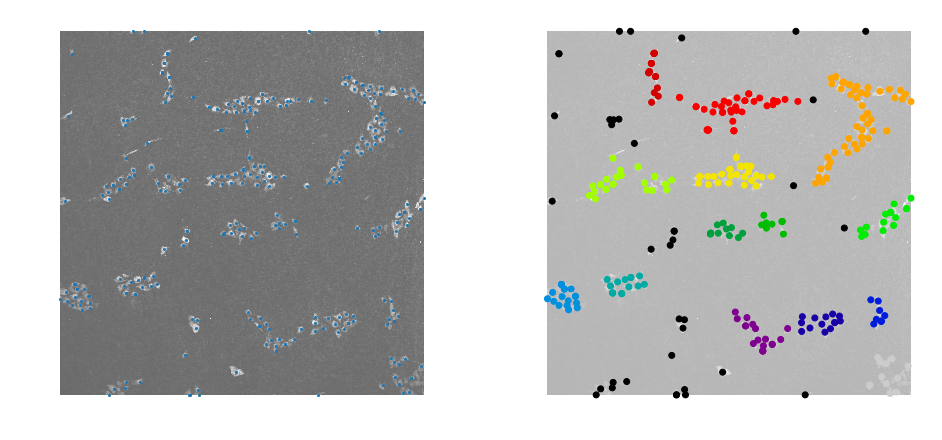

In [56]:
fig, (ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                       sharex=True, sharey=True)
ax[0].imshow(img, alpha=0.6)
ax[0].scatter(local_maxi[:,1], local_maxi[:,0], s=4)

ax[1].imshow(img, alpha=0.3)
ax[1].scatter(local_maxi[:,1], local_maxi[:,0], c=label_plot, cmap = "nipy_spectral")

for axes in ax:
    axes.axis('off')
#plt.savefig('cluster.png',dpi=300)

In [57]:
test = np.zeros(dist.shape, dtype=np.int)

In [58]:
for pos, new in zip(local_maxi, db.labels_):
    if new > 0:
        test[pos[0], pos[1]] = new
    elif new == 0:
        test[pos[0], pos[1]] = max(labels) + 1

In [59]:
test = dilation(test, disk(10))

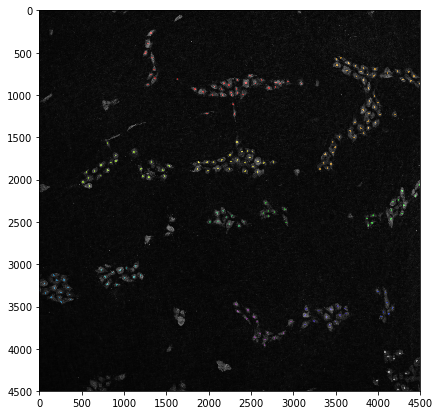

In [60]:
plt.imshow(img)
plt.imshow(test, cmap = "nipy_spectral", alpha = 0.5)

In [61]:
smoothed = ndi.gaussian_filter(img, 10)

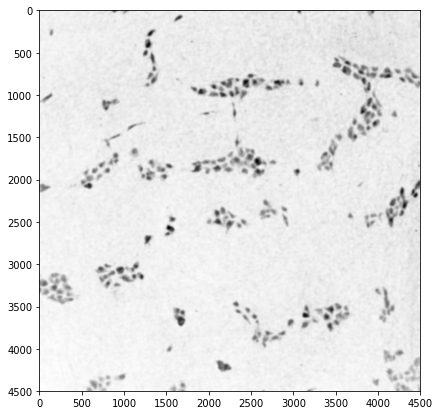

In [62]:
plt.imshow(-smoothed)

In [63]:
binary_water = img_relabel > thresh*0.8
mask_water = binary.astype(bool)
dist_water = ndi.distance_transform_edt(binary_water)

In [64]:
segmentation_ws = watershed(-smoothed, test, mask = binary_water)

/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


In [65]:
from skimage.color import label2rgb

image_label_overlay = label2rgb(segmentation_ws, image=img, bg_label=0)

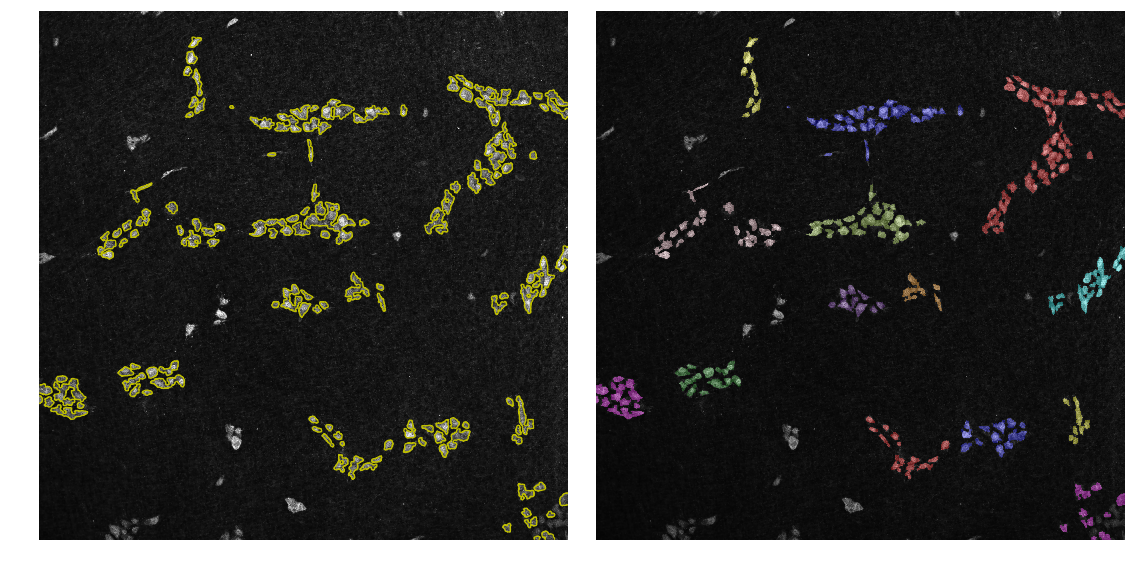

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
axes[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation_ws, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

In [67]:
ganglion_prop = regionprops(segmentation_ws)

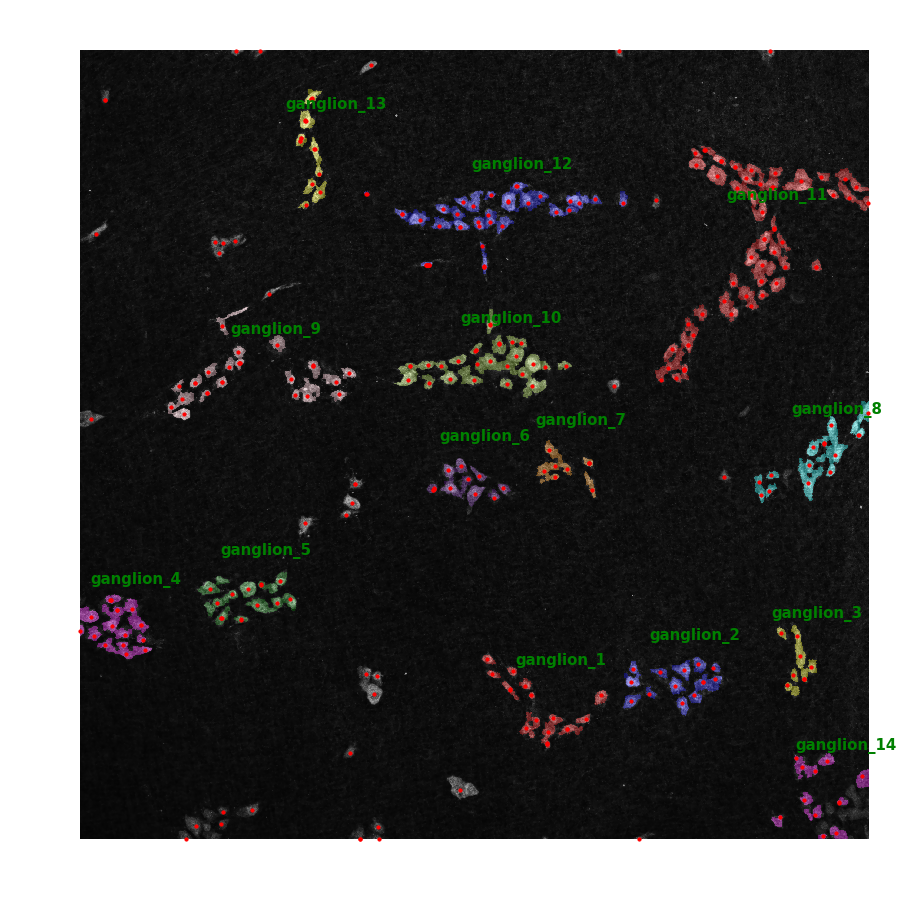

In [68]:
fig,ax = plt.subplots(1,1, figsize=(16,16))

ax.imshow(image_label_overlay, interpolation='nearest')
ax.axis('off')
ax.scatter(local_maxi[:, 1], local_maxi[:, 0], c='red',s = 10)


for prop in ganglion_prop:
    ax.annotate("ganglion_{}".format(prop.label), 
                (prop.centroid[1]-150, prop.centroid[0]-250), color='green', 
                fontsize=15, weight = "bold")

#plt.savefig('ganglions.png',dpi=300)

In [69]:
filled_ganglion = [prop.coords for prop in ganglion_prop]

# Creating the dataframe

In [70]:
import pandas as pd

/Users/Espenel/anaconda/envs/julia/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [71]:
result = []
for prop in ganglion_prop:
    coord = prop.coords
    #find neurons in ganglion
    a = np.in1d(local_maxi[:,0], coord[:,0])
    b = np.in1d(local_maxi[:,1], coord[:,1])
    c = np.where(a == True)[0]
    d = np.where(b == True)[0]
    e = np.in1d(c,d)
    number_of_neurons = len(np.where(e == True)[0])
    label = prop.label
    result.append((label, number_of_neurons))
result = np.asarray(result)

In [72]:
surface_gang = [prop.area for prop in ganglion_prop]

In [73]:
major_gang = [prop.major_axis_length for prop in ganglion_prop] 

/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/Espenel/anaconda/envs/julia/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [74]:
minor_gang = [prop.minor_axis_length for prop in ganglion_prop] 

In [75]:
orientation_gang = [prop.orientation for prop in ganglion_prop] 

In [76]:
df = pd.DataFrame(result, columns = ['ganglion', 'Nbr of neurons'])

In [77]:
df["surface ganglion"] = surface_gang

In [78]:
df["major axis length"] = major_gang

In [79]:
df["minorm axis length"] = minor_gang

In [80]:
df["orientation"] = orientation_gang

In [81]:
df.loc[:, 'major axis length']*=(meta['PhysicalSizeX'])

In [82]:
df.loc[:, 'minorm axis length']*=(meta['PhysicalSizeX'])

In [83]:
df = df.rename(columns={"minorm axis length": "minor axis length in µm"})

In [84]:
df = df.rename(columns={"major axis length": "major axis length in µm"})

In [85]:
df = df.rename(columns={"surface ganglion": "surface ganglion in µm2"})

In [86]:
df = df.replace({"ganglion" : 0},"background")

In [87]:
df.loc[-1] =  np.nan

In [88]:
df.index = df.index +1

In [89]:
df = df.sort_index() 

In [90]:
df['ganglion'][0] = "background"

In [91]:
df.loc[0,"Nbr of neurons"] = len(local_maxi)

In [92]:
df

ganglion  Nbr of neurons  surface ganglion in µm2  \
0   background           340.0                      NaN   
1            1            18.0                  45459.0   
2            2            14.0                  58477.0   
3            3             9.0                  24677.0   
4            4            18.0                  61292.0   
5            5            15.0                  57729.0   
6            6            13.0                  36875.0   
7            7             9.0                  25020.0   
8            8            16.0                  67748.0   
9            9            28.0                  80484.0   
10          10            29.0                 110322.0   
11          11            63.0                 212259.0   
12          12            43.0                 110508.0   
13          13            17.0                  33482.0   
14          14            12.0                  40401.0   

    major axis length in µm  minor axis length in µm  orientation  
0                       NaN                      NaN          NaN  
1                133.614695                70.341251    -0.528433  
2                107.974459                49.427864     0.095228  
3                 72.895178                30.904993    -1.439247  
4                 71.224063                56.197425    -0.578746  
5                103.141804                44.575547     0.063881  
6                 72.149597                37.845318    -0.206798  
7                 69.971151                38.523701    -0.398438  
8                138.478763                42.511783     0.677168  
9                216.787234                88.581552     0.058620  
10               159.462396                57.358507     0.064081  
11               277.810203               140.544132     1.032552  
12               205.485045                53.432106     0.129476  
13               133.025189                24.375768    -1.507397  
14                99.353690                91.208623     1.294733

In [93]:
#df.to_csv('{}.csv'.format(meta["Name"]))